# Comparison of Models' Explainabilities

## Set Up

In [1]:
# Move the current path to the repo
%cd "../cockatiel/"

C:\Users\onurp\Desktop\Analitik\cockatiel


In [2]:
# Enable automatical module reload
%load_ext autoreload
%autoreload 2

In [3]:
import torch

# Set up GPU if it is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Selected component:", device)

Selected component: cuda


## Util Functions

In [4]:
import matplotlib.pyplot as plt  

def plot_glob_importances(global_importance_pos, global_importance_neg):

    plt.figure(figsize=(22, 5))

    plt.subplot(121)
    cm = plt.get_cmap('tab20')
    plt.bar(range(len(global_importance_pos)), global_importance_pos, color=cm.colors, tick_label=range(len(global_importance_pos)))
    plt.title("Concepts for Positive Class")

    plt.subplot(122)
    cm = plt.get_cmap('tab20')
    plt.bar(range(len(global_importance_pos)), global_importance_neg, color=cm.colors, tick_label=range(len(global_importance_neg)))
    plt.title("Concepts for Negative Class")

    plt.show()
    
    return None

In [5]:
from cockatiel import occlusion_concepts, print_legend, viz_concepts
import numpy as np

def plot_reviews_exp(segments_pos, u_segments_pos, factorization_pos, global_importance_pos,
                     segments_neg, u_segments_neg, factorization_neg, global_importance_neg,
                     custom_samples, samples_to_test=None
                    ):
    
    # Find Concept IDs
    
    m_pos = 2 # Number of concept looked for the positive class 
    m_neg = 3 # Number of concept looked for the negative class

    l_concept_id_pos = np.argsort(global_importance_pos)[::-1][:m_pos]
    l_concept_id_neg = np.argsort(global_importance_neg)[::-1][:m_neg]

        
    # Prepare sample text
    
    if custom_samples is True:
    
        l_mip_sentences_neg = np.array(samples_to_test[0])
        l_mip_sentences_pos = np.array(samples_to_test[1])
        
        n = len(l_mip_sentences_neg)    # Number of reviews for each labels and each concept
    
    elif custom_samples is False:
        
        # Find most important sentences that are associated with most important concepts
        
        n = 10
        
        l_mip_sentences_pos, l_mip_sentences_neg = [], []

        # Add sentence of positive label
        for concept_id in l_concept_id_pos:

            mip_sentences_ids = np.argsort(u_segments_pos[:, concept_id])[::-1][:n]
            mip_sentences = np.array(segments_pos)[mip_sentences_ids]
            l_mip_sentences_pos.append(mip_sentences)

        # Add sentence of negative label
        for concept_id in l_concept_id_neg:

            mip_sentences_ids = np.argsort(u_segments_neg[:, concept_id])[::-1][:n]
            mip_sentences = np.array(segments_neg)[mip_sentences_ids]
            l_mip_sentences_neg.append(mip_sentences)

        l_mip_sentences_pos = np.array(l_mip_sentences_pos)
        l_mip_sentences_pos = l_mip_sentences_pos.flatten()
        l_mip_sentences_neg = np.array(l_mip_sentences_neg)
        l_mip_sentences_neg = l_mip_sentences_neg.flatten()
    
    # Create dictionnaries for legend with a color for each concept:
    # Use m_pos+m_neg concepts, so we have to create a dictionnary "colors" with m_pos+m_neg colors. 
    # In the dictionnary "label_to_criterion", add the corresponding concept for each color.

    colors = {
        0: "rgba(9, 221, 55, ", #green
        1: "rgba(9, 221, 161, ", #turquoise
        #2: "rgba(9, 175, 221, ", #blue
        2: "rgba(221, 9, 34, ", #red
        3: "rgba(221, 9, 140,", #pink
        4: "rgba(221, 90, 9, ", #orange
    }

    label_to_criterion = {
        0: "Positive label: concept1",
        1: "Positive label: concept2",
        #2: "Positive label: concept3",
        2: "Negative label: concept1",
        3: "Negative label: concept2",
        4: "Negative label: concept3",
    }


    #sanity check:
    if len(label_to_criterion.keys()) != len(colors.keys()) or len(label_to_criterion.keys()) != (m_pos + m_neg):
        print("Error: check that you have the correct number of colors and labels in your dictionaries to cover the number of concepts being looked at")
        
        
        
    print_legend(colors, label_to_criterion)

    print("positive predicted reviews:")
    print("\n")
    i = 0
    for sentence in l_mip_sentences_pos:
        if i%n == 0 :
            print("\n")
            print(str(n) + " most important reviews for positive predicted label - concept" + str(i//n + 1) +":")
            print("\n")
        phi = occlusion_concepts(sentence, model, tokenizer, [factorization_pos, factorization_neg], [l_concept_id_pos, l_concept_id_neg], ignore_words = [], two_labels = True, device = device)
        phi /= np.max(np.abs(phi)) + 1e-5
        viz_concepts(sentence, phi, colors, ignore_words = [])
        i += 1

    print("\n")
    print("negative predicted reviews:")
    print("\n")

    i = 0
    for sentence in l_mip_sentences_neg:

        if i%n == 0 :
            print("\n")
            print(str(n) + " most important reviews for negative predicted label - concept" + str(i//n + 1) +":")
            print("\n")
        phi = occlusion_concepts(sentence,  model, tokenizer, [factorization_pos, factorization_neg], [l_concept_id_pos, l_concept_id_neg], ignore_words = [], two_labels = True, device = device)
        phi /= np.max(np.abs(phi)) + 1e-5
        viz_concepts(sentence, phi, colors, ignore_words = [])
        i +=1
        
    return None

2023-10-22 21:57:53,800 SequenceTagger predicts: Dictionary with 47 tags: O, S-NP, B-NP, E-NP, I-NP, S-VP, B-VP, E-VP, I-VP, S-PP, B-PP, E-PP, I-PP, S-ADVP, B-ADVP, E-ADVP, I-ADVP, S-SBAR, B-SBAR, E-SBAR, I-SBAR, S-ADJP, B-ADJP, E-ADJP, I-ADJP, S-PRT, B-PRT, E-PRT, I-PRT, S-CONJP, B-CONJP, E-CONJP, I-CONJP, S-INTJ, B-INTJ, E-INTJ, I-INTJ, S-LST, B-LST, E-LST, I-LST, S-UCP, B-UCP, E-UCP, I-UCP, <START>, <STOP>


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\onurp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\onurp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Comparison of Models

### Common Test Set

In [59]:
# ###### the killings are stupid and / or unimaginative bulamadım

# substring = "unimaginative"

# for index, string in enumerate(segments_neg):
#     if substring in string:
#         print(f"Substring '{substring}' found in string at index {index}: {string}")

Substring 'unimaginative' found in string at index 4144: Rather unimaginative direction, too.
Substring 'unimaginative' found in string at index 5231: I don't recommend this lame and unimaginative show to anyone.
Substring 'unimaginative' found in string at index 5312: These two great actors humiliate themselves all the way through by performing a number of irrelevant, unimaginative and kitch to the extreme (not that this is bad on its own)sketches that are supposed to make people laugh, but fail to do so.
Substring 'unimaginative' found in string at index 5714: Terrible acting, dialogue that was unimaginative and pathetic (let alone completely inappropriate for supposedly being in the 1800s), and oh, did I mention a battery pack prominently displayed on the back of one of the characters.
Substring 'unimaginative' found in string at index 6123: Cheap, amateurish, unimaginative, exploitative.
Substring 'unimaginative' found in string at index 9474: Relying on gratuitous profanity and po

In [9]:
# indices_neg = [35253, 29729, 35285, 14800, 14720, 31318, 15747]
# reviews_neg = np.array(segments_neg)[indices_neg]
# print(reviews_neg)

# indices_pos = [10108, 15711, 24157, 4142, 8211, 16541, 31384, 39364]
# reviews_pos = np.array(segments_pos)[indices_pos]
# print(reviews_pos)

["I couldn't even follow the plot, but suffice it to say, this is the absolute worst movie I have ever seen in my life."
 "This is by far one of the worst films I've ever paid good money to see."
 'Words cannot begin to describe how blandly terrible this movie is.'
 "It's pointless." 'Plot is unimportant.'
 'About the only good thing about this is the setting.'
 "It's too bad because this film had great production values and a good cast, but isn't the idea of turning a book into a movie (TV or film) to get the people who read the book to be part of the audience."]
['One of the best movies ever, hands down.'
 'It is simply one of my all-time favorite films.'
 'Very inspiring and encouraging to all ages.'
 'The ballroom scenes were very nice, the dancing and the outfits looked beautiful.'
 "Billy Bitzer's camera work is quite good."
 'The humor and sadness are subtly blended.'
 'Idrissa Oudraogo ( Burkina Faso ): from one of the poorest country in the world, a tender and funny story abou

In [6]:
reviews_neg = [
    "I couldn't even follow the plot, but suffice it to say, this is the absolute worst movie I have ever seen in my life.",
    "This is by far one of the worst films I've ever paid good money to see.",
    'Words cannot begin to describe how blandly terrible this movie is.',
    "It's pointless.",
    'Plot is unimportant.',
    'About the only good thing about this is the setting.',
    "It's too bad because this film had great production values and a good cast, but isn't the idea of turning a book into a movie (TV or film) to get the people who read the book to be part of the audience."
]

reviews_pos = [
    'One of the best movies ever, hands down.',
    'It is simply one of my all-time favorite films.',
    'Very inspiring and encouraging to all ages.',
    'The ballroom scenes were very nice, the dancing and the outfits looked beautiful.',
    "Billy Bitzer's camera work is quite good.",
    'The humor and sadness are subtly blended.',
    'Idrissa Oudraogo ( Burkina Faso ): from one of the poorest country in the world, a tender and funny story about five boys who want to capture Osama Bin Laden.',
    'Especially fun is the performance by Cronenberg as the truly evil human doctor who is bent on destroying the Nightbreed.'
]

### RoBERTa

In [6]:
# Load the model and its tokenizer

from transformers import RobertaTokenizerFast
from cockatiel import CustomRobertaForSequenceClassification, batch_predict, batcher, tokenize

tokenizer = RobertaTokenizerFast.from_pretrained("wrmurray/roberta-base-finetuned-imdb")
model = CustomRobertaForSequenceClassification.from_pretrained("wrmurray/roberta-base-finetuned-imdb").to(device)

# Put model into evaluation mode
model = model.eval()



import pickle

# Segments and global importances for positive class

segments_pos = pickle.load(open("../Tez/data/for_roberta/segments_pos.pkl",'rb'))
u_segments_pos = pickle.load(open("../Tez/data/for_roberta/u_segments_pos.pkl",'rb'))
factorization_pos = pickle.load(open("../Tez/data/for_roberta/factorization_pos.pkl",'rb'))
global_importance_pos = pickle.load(open("../Tez/data/for_roberta/global_importance_pos.pkl",'rb'))

# Segments and global importances for negative class

segments_neg = pickle.load(open("../Tez/data/for_roberta/segments_neg.pkl",'rb'))
u_segments_neg = pickle.load(open("../Tez/data/for_roberta/u_segments_neg.pkl",'rb'))
factorization_neg = pickle.load(open("../Tez/data/for_roberta/factorization_neg.pkl",'rb'))
global_importance_neg = pickle.load(open("../Tez/data/for_roberta/global_importance_neg.pkl",'rb'))

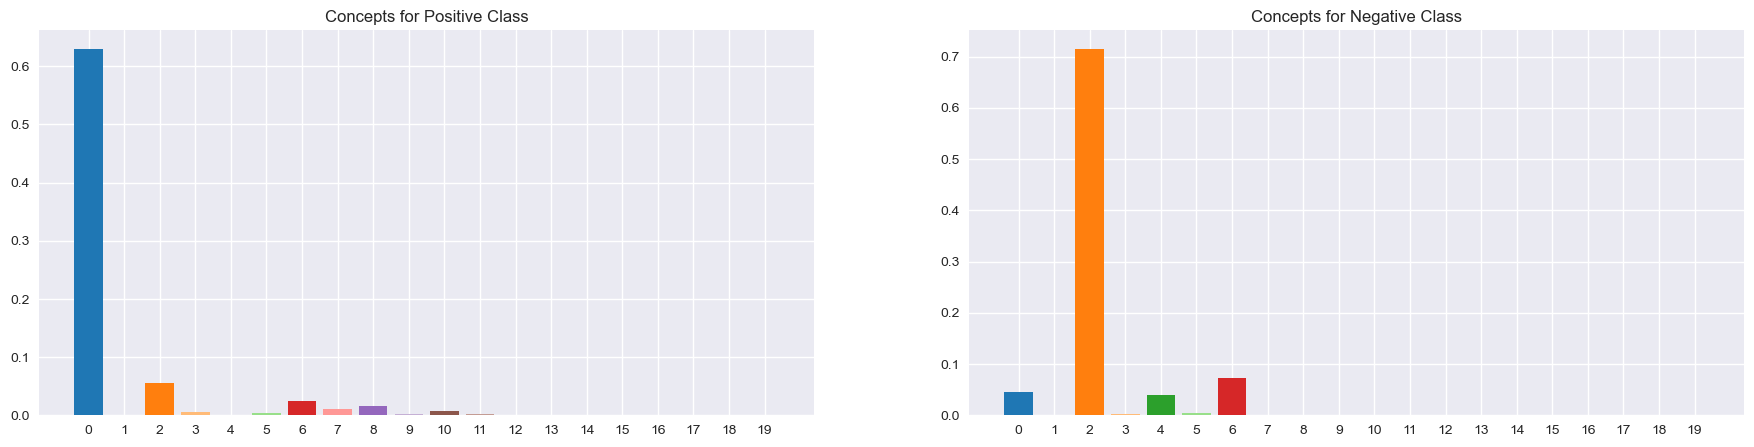

In [7]:
plot_glob_importances(global_importance_pos, global_importance_neg)

In [20]:
plot_reviews_exp(segments_pos, u_segments_pos, factorization_pos, global_importance_pos,
                 segments_neg, u_segments_neg, factorization_neg, global_importance_neg,
                 custom_samples=False)

positive predicted reviews:




10 most important reviews for positive predicted label - concept1:






10 most important reviews for positive predicted label - concept2:






negative predicted reviews:




10 most important reviews for negative predicted label - concept1:






10 most important reviews for negative predicted label - concept2:






10 most important reviews for negative predicted label - concept3:




In [63]:
plot_reviews_exp(segments_pos, u_segments_pos, factorization_pos, global_importance_pos,
                 segments_neg, u_segments_neg, factorization_neg, global_importance_neg,
                 custom_samples=True, samples_to_test=[reviews_neg, reviews_pos])

positive predicted reviews:




7 most important reviews for positive predicted label - concept1:






7 most important reviews for positive predicted label - concept2:






negative predicted reviews:




7 most important reviews for negative predicted label - concept1:




### AlBERT

In [7]:
# Load the model and its tokenizer

from transformers import AlbertTokenizerFast
from cockatiel import CustomAlbertForSequenceClassification, batch_predict, batcher, tokenize

tokenizer = AlbertTokenizerFast.from_pretrained("Ibrahim-Alam/finetuning-albert-base-v2-on-imdb")
model = CustomAlbertForSequenceClassification.from_pretrained("Ibrahim-Alam/finetuning-albert-base-v2-on-imdb").to(device)

# Put model into evaluation mode
model = model.eval()



import pickle

# Segments and global importances for positive class

segments_pos = pickle.load(open("../Tez/data/for_albert/segments_pos.pkl",'rb'))
u_segments_pos = pickle.load(open("../Tez/data/for_albert/u_segments_pos.pkl",'rb'))
factorization_pos = pickle.load(open("../Tez/data/for_albert/factorization_pos.pkl",'rb'))
global_importance_pos = pickle.load(open("../Tez/data/for_albert/global_importance_pos.pkl",'rb'))

# Segments and global importances for negative class

segments_neg = pickle.load(open("../Tez/data/for_albert/segments_neg.pkl",'rb'))
u_segments_neg = pickle.load(open("../Tez/data/for_albert/u_segments_neg.pkl",'rb'))
factorization_neg = pickle.load(open("../Tez/data/for_albert/factorization_neg.pkl",'rb'))
global_importance_neg = pickle.load(open("../Tez/data/for_albert/global_importance_neg.pkl",'rb'))

Some weights of CustomAlbertForSequenceClassification were not initialized from the model checkpoint at Ibrahim-Alam/finetuning-albert-base-v2-on-imdb and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


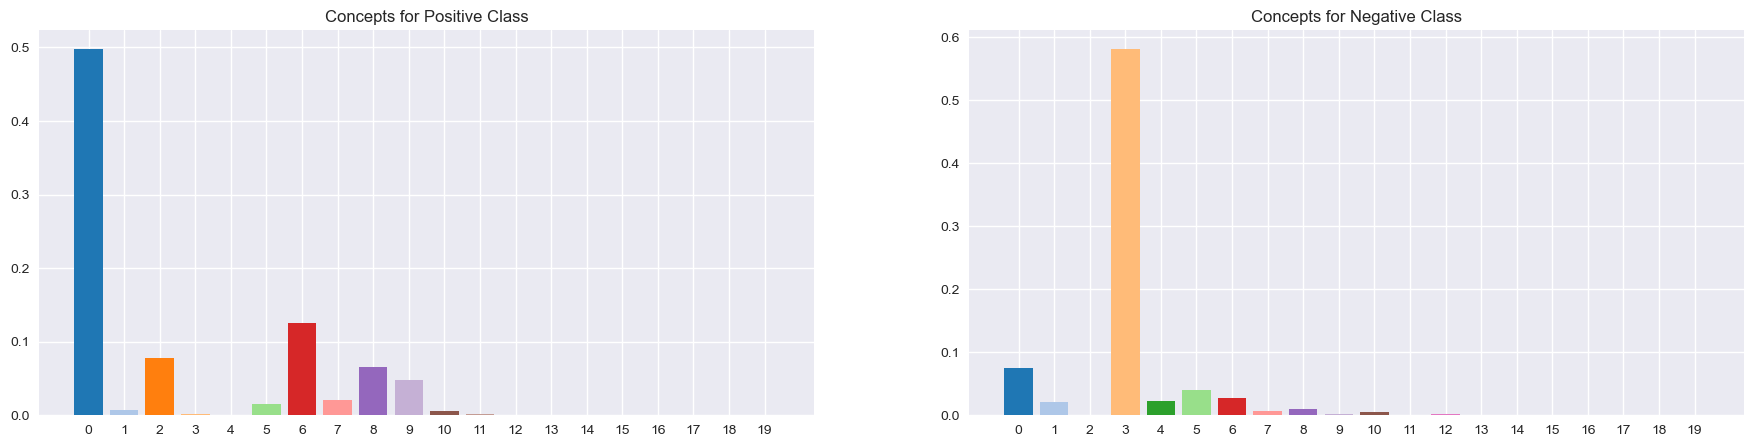

In [8]:
plot_glob_importances(global_importance_pos, global_importance_neg)

In [9]:
plot_reviews_exp(segments_pos, u_segments_pos, factorization_pos, global_importance_pos,
                 segments_neg, u_segments_neg, factorization_neg, global_importance_neg,
                 custom_samples=False)

positive predicted reviews:




10 most important reviews for positive predicted label - concept1:






10 most important reviews for positive predicted label - concept2:






negative predicted reviews:




10 most important reviews for negative predicted label - concept1:






10 most important reviews for negative predicted label - concept2:






10 most important reviews for negative predicted label - concept3:




In [10]:
plot_reviews_exp(segments_pos, u_segments_pos, factorization_pos, global_importance_pos,
                 segments_neg, u_segments_neg, factorization_neg, global_importance_neg,
                 custom_samples=True, samples_to_test=[reviews_neg, reviews_pos])

positive predicted reviews:




7 most important reviews for positive predicted label - concept1:






7 most important reviews for positive predicted label - concept2:






negative predicted reviews:




7 most important reviews for negative predicted label - concept1:




### DistilBERT

In [8]:
# Load the model and its tokenizer

from transformers import DistilBertTokenizerFast
from cockatiel import CustomDistilbertForSequenceClassification, batch_predict, batcher, tokenize

tokenizer = DistilBertTokenizerFast.from_pretrained("federicopascual/finetuned-sentiment-analysis-model")
model = CustomDistilbertForSequenceClassification.from_pretrained("federicopascual/finetuned-sentiment-analysis-model").to(device)

# Put model into evaluation mode
model = model.eval()



import pickle

# Segments and global importances for positive class

segments_pos = pickle.load(open("../Tez/data/for_distilbert/segments_pos.pkl",'rb'))
u_segments_pos = pickle.load(open("../Tez/data/for_distilbert/u_segments_pos.pkl",'rb'))
factorization_pos = pickle.load(open("../Tez/data/for_distilbert/factorization_pos.pkl",'rb'))
global_importance_pos = pickle.load(open("../Tez/data/for_distilbert/global_importance_pos.pkl",'rb'))

# Segments and global importances for negative class

segments_neg = pickle.load(open("../Tez/data/for_distilbert/segments_neg.pkl",'rb'))
u_segments_neg = pickle.load(open("../Tez/data/for_distilbert/u_segments_neg.pkl",'rb'))
factorization_neg = pickle.load(open("../Tez/data/for_distilbert/factorization_neg.pkl",'rb'))
global_importance_neg = pickle.load(open("../Tez/data/for_distilbert/global_importance_neg.pkl",'rb'))

Some weights of CustomDistilbertForSequenceClassification were not initialized from the model checkpoint at federicopascual/finetuned-sentiment-analysis-model and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


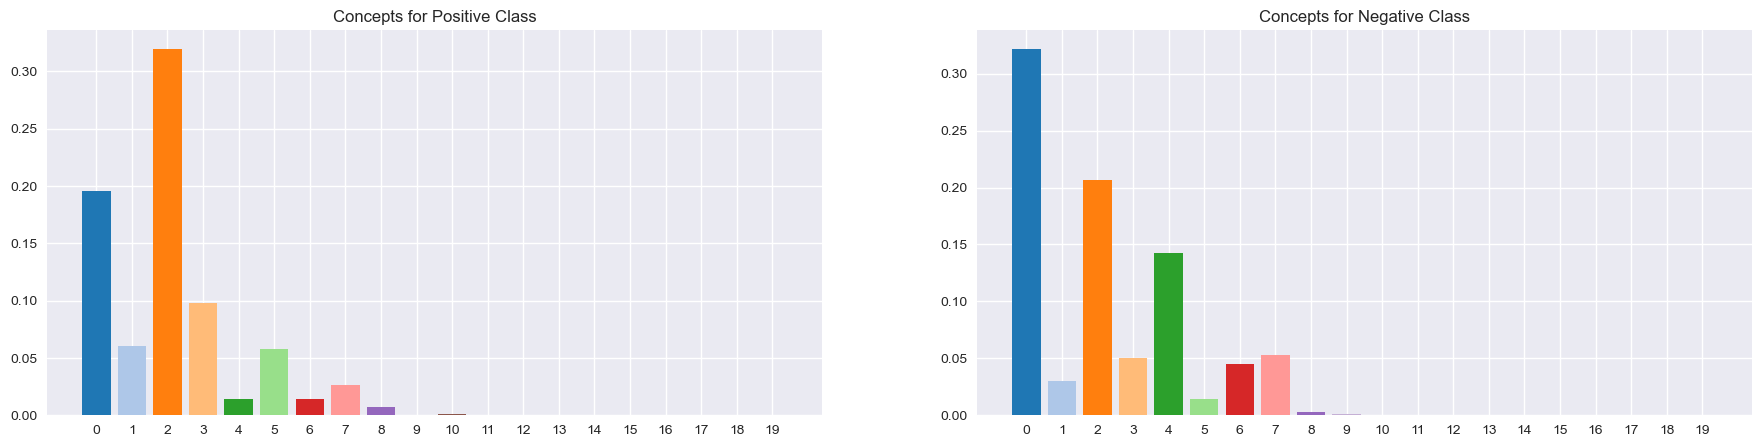

In [9]:
plot_glob_importances(global_importance_pos, global_importance_neg)

In [10]:
plot_reviews_exp(segments_pos, u_segments_pos, factorization_pos, global_importance_pos,
                 segments_neg, u_segments_neg, factorization_neg, global_importance_neg,
                 custom_samples=False)

positive predicted reviews:




10 most important reviews for positive predicted label - concept1:






10 most important reviews for positive predicted label - concept2:






negative predicted reviews:




10 most important reviews for negative predicted label - concept1:






10 most important reviews for negative predicted label - concept2:






10 most important reviews for negative predicted label - concept3:




In [11]:
plot_reviews_exp(segments_pos, u_segments_pos, factorization_pos, global_importance_pos,
                 segments_neg, u_segments_neg, factorization_neg, global_importance_neg,
                 custom_samples=True, samples_to_test=[reviews_neg, reviews_pos])

positive predicted reviews:




7 most important reviews for positive predicted label - concept1:






7 most important reviews for positive predicted label - concept2:






negative predicted reviews:




7 most important reviews for negative predicted label - concept1:




In [8]:
from cockatiel import occlusion_concepts, print_legend, viz_concepts
import numpy as np

n = 10 #number of reviews for each labels and each concept
m_pos = 2 #number of concept looked for the positive class (we look the m_pos more importants)
m_neg = 3 #number of concept looked for the negative class (we look the m_neg more importants)

l_concept_id_pos = np.argsort(global_importance_pos)[::-1][:m_pos]
l_concept_id_neg = np.argsort(global_importance_neg)[::-1][:m_neg]

l_mip_sentences_pos, l_mip_sentences_neg = [], []

# Add sentence of positive label

for concept_id in l_concept_id_pos:

    mip_sentences_ids = np.argsort(u_segments_pos[:, concept_id])[::-1][:n]
    mip_sentences = np.array(segments_pos)[mip_sentences_ids]
    l_mip_sentences_pos.append(mip_sentences)
    
    # Print the sentences for each concept
    print(f"Top sentences for Positive Concept {concept_id}:")
    for i, sentence in enumerate(mip_sentences):
        print(f"{i + 1}: {sentence}")
    print("\n")

# Add sentence of negative label

for concept_id in l_concept_id_neg:

    mip_sentences_ids = np.argsort(u_segments_neg[:, concept_id])[::-1][:n]
    mip_sentences = np.array(segments_neg)[mip_sentences_ids]
    l_mip_sentences_neg.append(mip_sentences)

l_mip_sentences_pos = np.array(l_mip_sentences_pos)
l_mip_sentences_pos = l_mip_sentences_pos.flatten()
l_mip_sentences_neg = np.array(l_mip_sentences_neg)
l_mip_sentences_neg = l_mip_sentences_neg.flatten()



# Create dictionnaries for legend with a color for each concept:
# Use m_pos+m_neg concepts, so we have to create a dictionnary "colors" with m_pos+m_neg colors. 
# In the dictionnary "label_to_criterion", add the corresponding concept for each color.

colors = {
    0: "rgba(9, 221, 55, ", #green
    1: "rgba(9, 221, 161, ", #turquoise
    #2: "rgba(9, 175, 221, ", #blue
    2: "rgba(221, 9, 34, ", #red
    3: "rgba(221, 9, 140,", #pink
    4: "rgba(221, 90, 9, ", #orange
}

label_to_criterion = {
    0: "Positive label: concept1",
    1: "Positive label: concept2",
    #2: "Positive label: concept3",
    2: "Negative label: concept1",
    3: "Negative label: concept2",
    4: "Negative label: concept3",
}


#sanity check:
if len(label_to_criterion.keys()) != len(colors.keys()) or len(label_to_criterion.keys()) != (m_pos + m_neg):
    print("Error: check that you have the correct number of colors and labels in your dictionaries to cover the number of concepts being looked at")



print_legend(colors, label_to_criterion)

print("positive predicted reviews:")
print("\n")
i = 0
for sentence in l_mip_sentences_pos:
    if i%n == 0 :
        print("\n")
        print(str(n) + " most important reviews for positive predicted label - concept" + str(i//n + 1) +":")
        print("\n")
    phi = occlusion_concepts(sentence, model, tokenizer, [factorization_pos, factorization_neg], [l_concept_id_pos, l_concept_id_neg], ignore_words = [], two_labels = True, device = device)
    phi /= np.max(np.abs(phi)) + 1e-5
    viz_concepts(sentence, phi, colors, ignore_words = [])
    i += 1

print("\n")
print("negative predicted reviews:")
print("\n")

i = 0
for sentence in l_mip_sentences_neg:

    if i%n == 0 :
        print("\n")
        print(str(n) + " most important reviews for negative predicted label - concept" + str(i//n + 1) +":")
        print("\n")
    phi = occlusion_concepts(sentence,  model, tokenizer, [factorization_pos, factorization_neg], [l_concept_id_pos, l_concept_id_neg], ignore_words = [], two_labels = True, device = device)
    phi /= np.max(np.abs(phi)) + 1e-5
    viz_concepts(sentence, phi, colors, ignore_words = [])
    i +=1

Top sentences for Positive Concept 0:
1: Directed by Samuel Fuller, who also wrote the screenplay, Pickup on South Street is a tough, brutal, well made film about a pickpocket (Richard Widmark) who inadvertently aquires top-secret microfilm and becomes a target for espionage agents.
2: Haunting long takes, a gritty soundtrack to accentuate the guilt, barking dogs.
3: It is a psychological thriller.
4: Standing out strongly is its sultrily lurid and bleak nature that's intrusively planted into the film's psychological makeup and manipulative strangle hold in sexual depravity.
5: The former prizefighter, who once faced Joe Louis in the ring, delivers an Academy Award-winning portrayal of disgraced IRA soldier Gypo Nolan on the worst night of his life.
6: A River Runs Through It is based on the true story of two fly fishing brothers, Norman and Paul, (Brad Pitt and Craig Sheffer) whose Reverend father (Tom Skerritt) is a strict man whose two passions are his faith and fly fishing, - and, 

positive predicted reviews:




10 most important reviews for positive predicted label - concept1:






10 most important reviews for positive predicted label - concept2:






negative predicted reviews:




10 most important reviews for negative predicted label - concept1:






10 most important reviews for negative predicted label - concept2:






10 most important reviews for negative predicted label - concept3:




#### Test on samples draft

In [25]:
sentences = negative_reviews

for sentence in sentences:

    phi = occlusion_concepts(sentence, model, tokenizer, [factorization_pos, factorization_neg], 
                             [l_concept_id_pos, l_concept_id_neg], ignore_words = [], extract_fct="clause", 
                             two_labels = True, device = device)
    
    phi /= np.max(np.abs(phi)) + 1e-5
    
    viz_concepts(sentence, phi, colors, ignore_words = [])

#### Concept text'lerini yazdırma - draft

In [23]:
from cockatiel import occlusion_concepts, print_legend, viz_concepts
import numpy as np

n = 10 #number of reviews for each labels and each concept
m_pos = 2 #number of concept looked for the positive class (we look the m_pos more importants)
m_neg = 3 #number of concept looked for the negative class (we look the m_neg more importants)

l_concept_id_pos = np.argsort(global_importance_pos)[::-1][:m_pos]
l_concept_id_neg = np.argsort(global_importance_neg)[::-1][:m_neg]

l_mip_sentences_pos, l_mip_sentences_neg = [], []

# Add sentence of positive label

for concept_id in l_concept_id_pos:

    mip_sentences_ids = np.argsort(u_segments_pos[:, concept_id])[::-1][:n]
    mip_sentences = np.array(segments_pos)[mip_sentences_ids]
    l_mip_sentences_pos.append(mip_sentences)

Top sentences for Positive Concept 0:
1: Directed by Samuel Fuller, who also wrote the screenplay, Pickup on South Street is a tough, brutal, well made film about a pickpocket (Richard Widmark) who inadvertently aquires top-secret microfilm and becomes a target for espionage agents.
2: Haunting long takes, a gritty soundtrack to accentuate the guilt, barking dogs.
3: It is a psychological thriller.
4: Standing out strongly is its sultrily lurid and bleak nature that's intrusively planted into the film's psychological makeup and manipulative strangle hold in sexual depravity.
5: The former prizefighter, who once faced Joe Louis in the ring, delivers an Academy Award-winning portrayal of disgraced IRA soldier Gypo Nolan on the worst night of his life.
6: A River Runs Through It is based on the true story of two fly fishing brothers, Norman and Paul, (Brad Pitt and Craig Sheffer) whose Reverend father (Tom Skerritt) is a strict man whose two passions are his faith and fly fishing, - and, 

In [35]:
segments_pos, u_segments_pos, factorization_pos, global_importance_pos

array([0, 2], dtype=int64)

In [42]:
global_importance_pos

array([6.3025874e-01, 5.2990275e-04, 5.4627560e-02, 6.0897958e-03,
       6.4521941e-05, 3.2928057e-03, 2.4939874e-02, 1.1226312e-02,
       1.5390346e-02, 2.0040879e-03, 8.0058854e-03, 2.4497129e-03,
       1.2709717e-04, 2.8340658e-04, 3.5288630e-04, 6.9555977e-06,
       5.2201084e-04, 6.8772490e-05, 6.0184843e-06, 2.5940142e-05],
      dtype=float32)

In [26]:
mip_sentences_ids

array([11217, 11615, 21227, 25806, 25795, 41604,  3233,  4704, 46838,
        8092], dtype=int64)

In [25]:
l_concept_id_pos

array([0, 2], dtype=int64)

In [28]:
u_segments_pos[0]

array([0.01092248, 0.        , 0.02173545, 0.04917249, 0.        ,
       0.        , 0.02094898, 0.02311426, 0.04949626, 0.        ,
       0.01856751, 0.13514405, 0.        , 0.        , 0.19958098,
       0.        , 0.07712366, 0.14546627, 0.        , 0.        ],
      dtype=float32)

In [ ]:
np.array(segments_pos)[mip_sentences_ids]